# KLCA Heuristic Algorithm
***
<p align="justify"> Many customers favor companies that offer shipping costs. According to a study conducted by <i>PayPal</i> and <i>ComScore</i>, 43% of French Internet users do not make a purchase, despite having put together a cart because of high shipping costs. In order to be more competitive and to attract more and more new customers, it is therefore interesting for a company to offer these shipping costs. This means that these costs will be pushed toward the company, which can impact the profitability and therefore the sustainability of the business. The decision to offer delivery costs should not be taken lightly and must be based on a solid, successful, and controlled strategy. This project consists of implementing a <b>k-link clustering algorithm</b> to optimize the allocation of product categories amongst a set of warehouses to <b>minimize the splitting of e-commerce orders</b> and lead to logistics cost reduction. This has a wide range of <b>different business applications</b> particularly in data mining to find patterns from network optimization to market basket analysis, and in the world of finance for portfolio optimization. </p>

***
## Project Set-Up
> - Importing all the **required libraries** for this project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## PRE-PROCESSING
> ***
> ### Data Preparation
> Here we want to read and compute e-commerce **orders data** in order to obtain the following parameters to be fed into the main algorithm. The key here is to map the order-category relationship in the data. Below are the notations used:
>
> - $i :$ index representing an order with $i=1,2,...,I$ 
> - $j :$ index representing different product-category with $j=1,2,...,J$
> - $k :$ index representing different warehouses with $k=1,2,...,K$ 
> - $o_{ij} :$ 2 dimentional binary matrix flagging the order $i$ / category $j$ relationship
>
> Below are the parameters of the problem:
> - $N_{max} :$ Maximum quantity of categories storable in a warehouse with $N_{max} \leq J$ 
> - $N_{min} :$ Minimum quantity of categories storable in a warehouse with $N_{min} \geq 0$ 
> - $I :$ Quantity of customer orders 
> - $J :$ Quantity of product categories
> - $K :$ Quantity of warehouses

In [2]:
def global_def():
    global orders, categories, warehouses, Card, NMin, NMax, Theta, NCO, INL, OUTL, in_link, outlink, L, o, x
    global I, J, K

In [3]:
def read_data_panda(file_path):
    global orders, categories, o
    global I, J
    
    'Dataset Structure Init'
    data_table = pd.read_csv(file_path, sep=',')
    index = data_table.index
    number_of_rows = len(index)
    
    'Data Lecture'
    orders = data_table.Orders.unique()
    categories = data_table.Category.unique()
    I = len(orders) #Number of order
    J = len(categories) #Number of categories
    orders = np.arange(1, len(orders)+1) #Set of order
    categories = np.arange(1, len(categories)+1) #Set of category
    
    'Resizing Data'
    o = np.zeros((I, J))
    
    'Data Implementation'
    Card_Order = np.zeros(I)
    line = 0
    num_order = 0
    current = data_table.loc[line, "Orders"]
    for step in range(I):
        while data_table.loc[line, "Orders"] == current and line < number_of_rows - 1:
            if o[num_order][data_table.loc[line, "Category"] - 1] == 0:
                Card_Order[num_order] = Card_Order[num_order] + 1
            o[num_order][data_table.loc[line, "Category"] - 1] = 1
            line = line + 1
        num_order = num_order + 1
        current = data_table.loc[line, "Orders"]
        
    'Check Plot'
    #plt.bar(orders, Card_Order)#plt.title('Category sum among orders', fontsize=10)#plt.ylabel("Nb of Categories")#plt.xlabel("Order")#plt.show()
    'End Plot'

In [4]:
def init_parameters():
    global K

    'NETWORK NODES'
    K = 3 #Number of warehouses

In [5]:
Path = 'data/data_order_shorten.csv' #15 Categories
Path2 = 'data/data_order.csv' #60 Categories

global_def()
read_data_panda(Path)
init_parameters()

> - Creating appropriate **data structures** for warehouses, orders and graphs based on the parameters.

In [6]:
def data_sizing(I,J,K):
    global warehouses, Card, NMin, NMax, Theta, NCO, INL, OUTL, L, x
    
    'Warehouses Parameters'
    warehouses = np.arange(K) #Warehouse Numbers
    Card=np.zeros((K)) #Filling Level
    NMin = np.full((K),2) #Min warehouse capacity #Assumed equals #Can be read as input
    NMax = np.full((K), 8) #Max warehouse capacity
    OUTL = np.zeros((K,K),dtype = float) #Outlinks between warehouses #Network arcs
    
    'Orders Parameters'
    Theta = np.zeros((I),dtype = float) #Coefficient updating to approach the real maximum split
    NCO = np.zeros((I),dtype = float) #Number of categories in order i
    
    'Graph Parameters'
    L = np.zeros((J,J),dtype = float) #Link Theta-Updated between categories
    INL = np.zeros((J,K),dtype = float) #Inlink between categories and warehouse
    x = np.zeros((J, K)) #Decision variable : Category unique allocation among set of warehouses

> ***
> ## Data Transformation
> We will first quantify the categories **pairwise-relationships** (also called affinity or co-appearance) within the Matrix $L()$ while applying a correcting coefficient $\theta$ further explained below:
>
>\begin{equation}
>L_{jq} = \displaystyle\sum\limits_{i=1}^{I} o_{ij}\times o_{iq}\times \theta_i,  \forall i \in I, j \ne q, q,j \in J
>\end{equation}

In [7]:
def link_init():
    global L, NCO, Theta, o
    
    'Category Network Building'
    link = np.zeros((I,J,J),dtype = float)
    for i in range(len(orders)):
        NCO[i] = count_NCO(i)
        Theta[i] = theta(NCO[i])
        if NCO[i] > 1:
            for j in range(len(categories)-1):
                for q in range(j+1, len(categories)):
                        link[i][j][q] = Theta[i]*o[i][j]*o[i][q] #Theta-Updated
                        link[i][q][j] = link[i][j][q] #Symmetry
                        L[j][q] = L[j][q] + link[i][j][q] #Summing
                        L[q][j] = L[j][q] #Symmetry

>Given a certain category-warehouse allocation (solution) we need to **quantify** the amount of category co-apperances being $inlinks$ (e.g. within the same warehouse) or $outlinks$ (e.g. between two warehouses). A category-warehouse allocation is stored within the following variable: 
> - $x_{jk} :$ binary equal to 1 if the category $j$  is stored in the warehouse $k$, 0 else.
>
> And the following notations are used:
>
> - $outlink_{jqkg} :$ representing link between category $j$ and $q$ between warehouse $k$ and $g$.
> - $inlink_{jqk} :$ representing link between category $j$ and $q$ within the warehouse $k$.
> - $OUTL_{kg} :$ representing sum of outlinks between warehouse $k$ and $g$.
> - $INL_{jk} :$ representing sum inlinks within warehouse $k$ caused by category $j$.

In [8]:
def matrix_init():
    global warehouses, categories, INL, OUTL, x, L
    global outlink, in_link
    
    'CATEGORY NETWORK AGGREGATION TO BUILD WAREHOUSE NETWORK'
    #Only once category are allocated among warehouses (x implemented)

    'Network Structure Init'
    in_link = np.zeros((J,J,K),dtype = float)
    outlink = np.zeros((J,J,K,K),dtype = float)
    INL = np.zeros((J,K),dtype = float)
    OUTL = np.zeros((K,K),dtype = float)
    
    'Warehouse Network Building'
    for k in range(len(warehouses)):
        for j in range(len(categories)-1):
            for q in range(j+1, len(categories)):
                in_link[j][q][k] = L[j][q]*x[j][k]*x[q][k]
                in_link[q][j][k] = in_link[j][q][k]
                INL[j][k] = INL[j][k] + in_link[j][q][k]
                INL[q][k] = INL[q][k] + in_link[q][j][k]
                for g in range(k+1, len(warehouses)):
                    if g != k :  #Not in_link imply : stored in another warehouse
                        outlink[j][q][k][g] = L[j][q]*x[j][k]*x[q][g]
                        outlink[q][j][g][k] = L[q][j]*x[j][k]*x[q][g]
                        outlink[j][q][g][k] = L[j][q]*x[j][g]*x[q][k]
                        outlink[q][j][k][g] = L[q][j]*x[j][g]*x[q][k]
                        OUTL[k][g]=OUTL[k][g] + outlink[j][q][k][g] + outlink[q][j][k][g]
                        OUTL[g][k]=OUTL[g][k] + outlink[q][j][g][k] + outlink[j][q][g][k]

> A given solution can be stored on a categories by warehouses matrix stored as $CW_{jk}$:

In [9]:
def matrix_init_CW():
    global categories, warehouses, x
        
    'Storing Allocation Solution'
    CW = np.zeros((J,K),dtype = float)
    for j in range(len(categories)):
        for k in range(len(warehouses)):
            CW[j][k]=x[j][k]
    return CW

> Using the notation $NCO_i$ to store the amount of categories present in order $i$:
> - $NCO_i = \sum_{j=1}^{J}{o_{ij}}$<br/>
>
> We have the **coefficient of connexion** theta defined as follow: (see mathematical explanation in the final report) 
> - $\theta_i = \frac{NCO_i - 1}{{NCO_i}\choose{2}} \ \forall i = 1..I$

In [10]:
def count_NCO(i):
    global categories, o
    
    'Category Count in one Order i'
    NCCount=0
    for j in range(len(categories)):
        NCCount = NCCount + o[i][j]
    return NCCount

In [11]:
def factorial(n):
    
    'FACTORIAL FUNCTION'
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

In [12]:
def combinatorial(n, k):
    
    'COMBINATORIAL FUNCTION'
    if n < k:
        return 0
    return (factorial(n))/(factorial(k)*factorial(n-k))

In [13]:
def theta(NCO):
    
    'THETA CORRECTION COEFFICIENT CALCULUS'
    if NCO < 2:
        return 1
    return (NCO-1)/(combinatorial(NCO, 2))

***
## ALGORITHM
> ***
> ### Objective Function
> Using the following notation:<br/>
>
> - $y_{ik} :$ binary equal to 1 if the order $i$ is shipped from the warehouse $k$, 0 else.<br/>
>
> The end goal of this problem is to **minimize the splitting order** defined as follow:<br/>
>
> - $Split = \sum_{i=1}^{I}(\sum_{k=1}^{K} {y_{ik}-1})$ <br/>
>
> Which can be approached using Linear Programming and solve using the **Simplex Algorithm** the following **LP**: (further detailed within the final report) <br/>
>
>\begin{equation}\begin{aligned}\text{Minimize}  & \displaystyle\sum\limits_{i=1}^{I}(\displaystyle\sum\limits_{k=1}^{K} y_{ik}-1)\\\end{aligned}\end{equation}\
>\begin{equation}\begin{aligned}\text{subject to :}\\ \newline \displaystyle\sum\limits_{k=1}^{K} x_{jk}=1, &  \forall j\\\end{aligned} \end{equation}
>\begin{equation}\begin{aligned}\displaystyle\sum\limits_ {j=1}^{J} x_{jk} \leq \text Nmax,  &\forall k\\ \end{aligned}\end{equation}
>\begin{equation}\begin{aligned}\displaystyle\sum\limits_ {j=1}^{J} x_{jk} \geq Nmin, &\forall k\\ \end{aligned}\end{equation}
>\begin{equation}\begin{aligned}\displaystyle y_{ik}\times J\geq \displaystyle\sum\limits_{j=1}^{J} x_{jk}\times o_{ij}, &\forall i ,  k \\ \end{aligned}\end{equation}
>\begin{equation}\begin{aligned}\newline\displaystyle x_{jk} \in {\{1,0\}}, \forall j,k\\\end{aligned}\end{equation}
>\begin{equation}\begin{aligned}\newline \displaystyle y_{ik} \in {\{1,0\}}, \forall i,k\\\end{aligned}\end{equation}
>
> This **LP** being **NP-Hard** such an approach would not fit actual real-world e-commerce company's data. Hence the heuristic proposed in this project. The heuristic approach will though minimize an **upper bound of the real order-split-sum** using the following **proxy function**:
>
> \begin{equation}
>\text{Minimize} \; LW = \displaystyle\sum\limits_{k=1}^{K-1}\displaystyle\sum\limits_{g=k+1}^{K}OUTL_{kg}
>\end{equation}
>
> Where given a certain feasible solution stored within **x** this could be defined as the upper-bound of the **sum of outlinks across warehouses**, where:
>
> \begin{equation} 
> outlink_{jqkg} = L_{jq} \times x_{jk}\times x_{qg}, \forall j, q, k, g, j \ne q, k \ne g 
>\end{equation}
>
>\begin{equation} 
>OUTL_{kg} = \displaystyle\sum\limits_{j=1}^{J-1}\displaystyle\sum\limits_{q=j+1}^{J} outlink_{jqkg}, \forall k, g, k \ne g 
>\end{equation}

In [14]:
def init_LW():
    global warehouses, OUTL
    
    'HEURISTIC OBJECTIVE FUNCTION CALCULATION'
    LW = 0
    for k in range(len(warehouses)-1):
        for g in range(k+1, len(warehouses)):
            LW = LW + OUTL[k][g]
    return LW

> We also need to calculate a **poor upper bound** of $LW$ as an order of magnitude and starting point for the expectation set on $LWs$ values computed later down the line.

In [15]:
def init_LWBest():
    global categories, L
        
    'LW UPPER BOUND CALCULATION'
    #Upper Bound of any LW solution-related value
    LW = 0
    for j in range(len(categories)-1):
        for q in range(j+1, len(categories)):
            LW = LW + L[j][q]
    return LW

> ***
> ### Improving Moves
> To converge towards a solution that has a low $LW$ function value this heuristic will perform two moves. 
> - **Relocation** of a category $j$ from a warehouse $k$ to another warehouse $g$ 
> 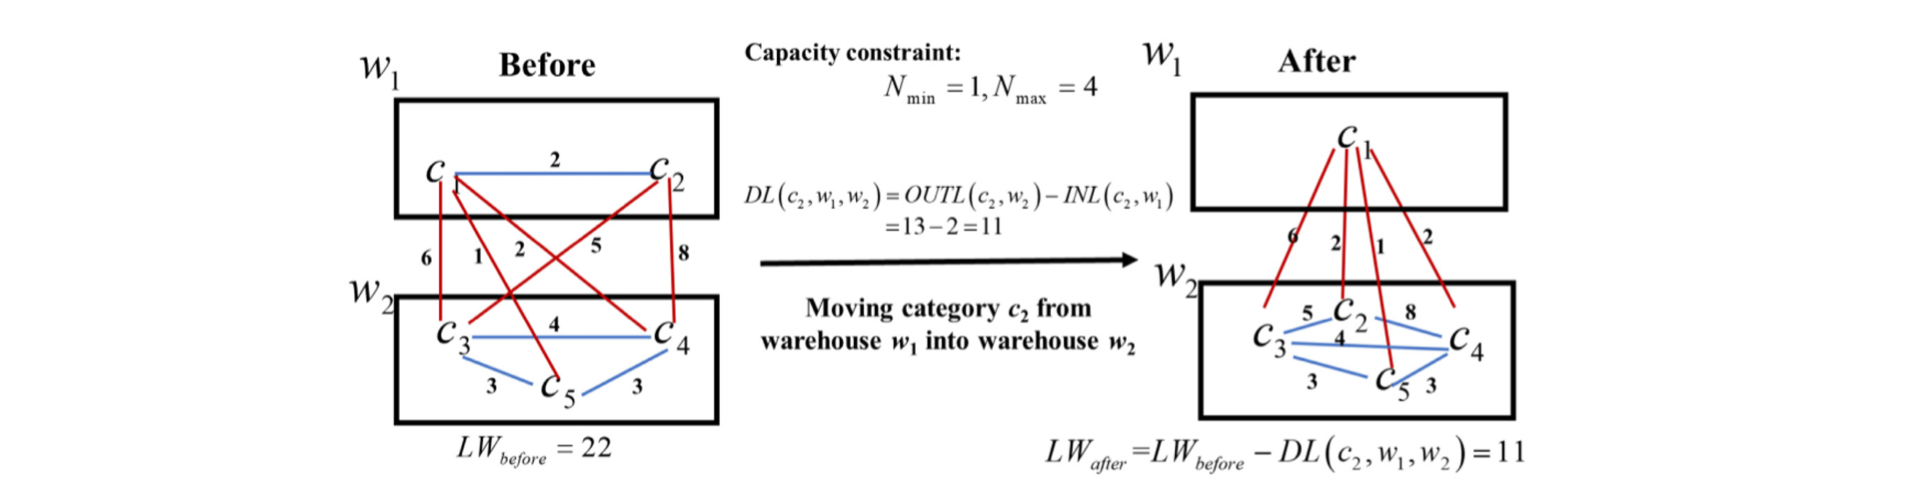
> - **Swap** of two categories $j, q$ from two different warehouses $k, g$ between each other
> 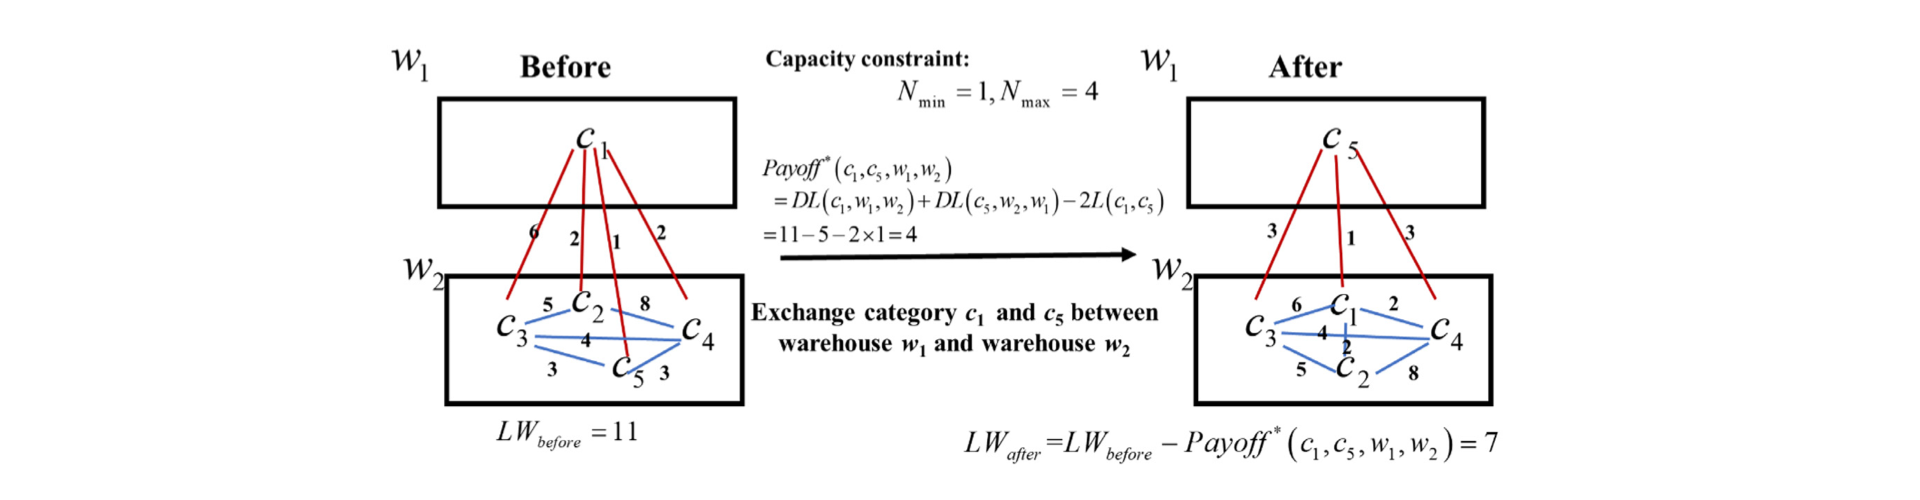
>
> With respective  **plus or minus value** impact of a move on $LW$ calculated as follow:
> - $DL_{jkg} = OUTL_{jg} -  INL_{jk}$
>
> - $Payoff_{jqkg} = DL_{jkg} + DL_{qgk} - 2\times L_{jq}$
>

In [16]:
def calcul_DL(category, current_warehouse, new_warehouse):
    global categories, outlink, OUTL, INL, x
        
    'RELOCATION PLUS OR MINUS VALUE CALCULATION'
    Count_OUTL = 0
    DL = 0
    for q in range(len(categories)):
        if x[q][new_warehouse] == 1 and q != category :
            Count_OUTL = Count_OUTL + outlink[category][q][current_warehouse][new_warehouse]
    DL=Count_OUTL - INL[category][current_warehouse]
    return DL

In [17]:
def calcul_payoff(cat1, cat2, war1, war2):
    global categories, outlink, OUTL, INL, x, L
    
    'EXCHANGE PLUS OR MINUS VALUE CALCULATION'
    payoff = 0
    DL1 = 0
    DL2 = 0
    DL1 = calcul_DL(cat1, war1, war2)
    DL2 = calcul_DL(cat2, war2, war1)
    payoff = DL1 + DL2 - (2 * L[cat1][cat2])
    if payoff < 0:
        return 0
    return payoff

> Once a move has been executed, the **graph data-structures** need to be **updated** (e.g. $inlink, outlink, INL, OUTL$) as many times as a category have been moved from one warehouse to another.

In [18]:
def matrix_update_relocate(category, current_warehouse, new_warehouse):
    global warehouses, categories, INL, OUTL, x, L
    global outlink, in_link
    
    'UPDATING THE WAREHOUSE NETWORK AFTER A RELOCATION MO'
    for j in range(len(categories)):
        #'DEALING WITH ALL THE CATEGORIES IN THE PREVIOUS WAREHOUSE'
        if j != category and x[j][current_warehouse] == 1:
            'Inlinks are now Outlinks'
            outlink[j][category][current_warehouse][new_warehouse] = in_link[j][category][current_warehouse]
            outlink[category][j][new_warehouse][current_warehouse] = in_link[category][j][current_warehouse]
            'Previous Warehouse INL Decreasing'
            INL[j][current_warehouse] = INL[j][current_warehouse] -  in_link[j][category][current_warehouse]
            INL[category][current_warehouse] = INL[category][current_warehouse] - in_link[category][j][current_warehouse]
            'OUTL Increasing'
            OUTL[current_warehouse][new_warehouse] = OUTL[current_warehouse][new_warehouse] + outlink[j][category][current_warehouse][new_warehouse]
            OUTL[new_warehouse][current_warehouse] = OUTL[current_warehouse][new_warehouse]
            'Inlinks are now equals to zero'
            in_link[j][category][current_warehouse] = 0
            in_link[category][j][current_warehouse] = 0
        #'DEALING WITH ALL THE CATEGORIES IN THE PREVIOUS WAREHOUSE'
        elif j != category and x[j][new_warehouse] == 1:
            'Outlinks are now Inlinks'
            in_link[j][category][new_warehouse] = outlink[j][category][new_warehouse][current_warehouse]
            in_link[category][j][new_warehouse] = outlink[category][j][current_warehouse][new_warehouse]
            'New Warehouse INL Increasing'
            INL[j][new_warehouse] = INL[j][new_warehouse] + in_link[j][category][new_warehouse]
            INL[category][new_warehouse] = INL[category][new_warehouse] + in_link[category][j][new_warehouse]
            'OUTL Decreasing'
            OUTL[current_warehouse][new_warehouse] = OUTL[current_warehouse][new_warehouse] - outlink[category][j][current_warehouse][new_warehouse]
            OUTL[new_warehouse][current_warehouse] = OUTL[current_warehouse][new_warehouse]
            'Outlinks are now equals to zero'
            outlink[j][category][new_warehouse][current_warehouse]  = 0
            outlink[category][j][current_warehouse][new_warehouse] = 0
        #'DEALING WITH ALL THE CATEGORIES IN THE OTHERS WAREHOUSES'
        elif j != category and x[j][new_warehouse] == 0 and x[j][current_warehouse] == 0:
            for k in range(len(warehouses)):
                if k != new_warehouse and k != current_warehouse and x[j][k] == 1:
                    'Oulink are now leading to the new warehouse'
                    outlink[j][category][k][new_warehouse] = outlink[j][category][k][current_warehouse]
                    outlink[category][j][new_warehouse][k] = outlink[category][j][current_warehouse][k]
                    'OUTL Correct Re-Assignment'
                    OUTL[current_warehouse][k] = OUTL[current_warehouse][k] - outlink[category][j][current_warehouse][k]
                    OUTL[new_warehouse][k] = OUTL[new_warehouse][k] + outlink[category][j][current_warehouse][k]
                    OUTL[k][current_warehouse] = OUTL[current_warehouse][k]
                    OUTL[k][new_warehouse] = OUTL[new_warehouse][k]
                    'Previous outlink are now equals to zero'
                    outlink[j][category][k][current_warehouse] = 0
                    outlink[category][j][current_warehouse][k] = 0
    #To avoid very little value (like 1.e-134)
    INL[category][current_warehouse] = 0

> Below are the actual executions of the two improving moves. The reason why we keep the word **improving** is because unlike neighborhood-exploring algorithms this heuristic will only make a move if it improves the objective function. To a further extent it is also a **greedy-algorithm** as it will always perform the most improving move over the first one or other decision rules.

In [19]:
def relocate_move(category, current_warehouse, new_warehouse):
    global Card, x
        
    'RELOCATION CATEGORY FROM ONE WAREHOUSE TO ANOTHER'
    #We made sure to update the filling levels and warehouse network
    x[category][current_warehouse] = 0
    Card[current_warehouse] = Card[current_warehouse] - 1
    x[category][new_warehouse] = 1
    Card[new_warehouse] = Card[new_warehouse] + 1
    matrix_update_relocate(category, current_warehouse, new_warehouse)

In [20]:
def exchange_move(category1, category2, warehouse1, warehouse2):
    global x
        
    'EXCHANGE CATEGORY FROM ONE WAREHOUSE TO ANOTHER'
    #We made sure to update the warehouse network
    x[category1][warehouse1] = 0
    x[category2][warehouse2] = 0
    x[category1][warehouse2] = 1
    x[category2][warehouse1] = 1
    matrix_update_relocate(category1, warehouse1, warehouse2)
    matrix_update_relocate(category2, warehouse2, warehouse1)

> ***
> ### Initital solution
> Before even starting any converging or improvement processes, optimization heuristics and algorithms starts with finding an initial **feasible solution**. The degree of **randomization versus. cleverness** of initial solutions is a whole area of research and improvements that will vary depending on the problem and the algorithm used as well as the dificulty of generating feasible solutions. In this algorithm, to explore a wide range of feasible solution we will leave this process **purely random** and generated as follow.

In [21]:
def randomize_category_allocation():
    global categories, warehouses, Card, NMin, NMax, x, K
    
    'FEASIBLE & RANDOMIZED SOLUTION BUILDING'
    #Could be replace by other heuristics
    
    'Data Init'
    x=np.zeros((J, K))
    Card=np.zeros((K))
    To_Place=list(categories)
    Not_Full=list(warehouses)
    
    'Minimum Capacity Requirement Completion'
    for k in range(len(warehouses)):
        if k == 0 and K*NMin[k] > len(To_Place): #Only bc NMin k is equal for all warehouses
            print('The capacity of the warehouses is too big (or too many warehouses). The prolem is not feasible.')
            break
        while Card[k] < NMin[k]:
            cat_to_place=To_Place[np.random.randint(0, len(To_Place))]
            x[cat_to_place - 1][k]=1
            Card[k]=Card[k] + x[cat_to_place - 1][k]
            To_Place.remove(cat_to_place)
        if Card[k] == NMax[k]: #Only if NMin == NMax
            Not_Full.remove(k)

    'Randomized allocation of a random quantity of category in the left-free-room in a randomly chosen warehouse'
    while len(To_Place) > 0:
        if len(Not_Full) == 0:
            print('The capacity of the warehouses is too little (or not enough warehouses). The prolem is not feasible.')
            break
        'Warehouse choice'
        k=Not_Full[np.random.randint(0, len(Not_Full))]
        'Quantity to place choice'
        if int(min((NMax[k] - Card[k]), len(To_Place))) <= 1:
            nb_to_place=1
        else:
            nb_to_place=np.random.randint(1, int(min((NMax[k] - Card[k]), len(To_Place))))
        'Category allocation'
        for choice in range(nb_to_place):
            cat_to_place=To_Place[np.random.randint(0, len(To_Place))]
            x[cat_to_place - 1][k]=1
            Card[k] = Card[k] + x[cat_to_place - 1][k]
            To_Place.remove(cat_to_place)
        if Card[k] == NMax[k]:
            Not_Full.remove(k)
            
    'Check Plot'
    #plt.bar(warehouses, Card)
    #plt.title('Category allocation among warehouses', fontsize=10)
    #plt.show()
    'End'

In [22]:
def error_check_allocation():
    global categories, warehouses, K, x
        
    'ERROR CHECKING OF A SOLUTION-RELATED CATEGORY ALLOCATION'
    SUM = np.zeros(K)
    
    'Ensuring all categories are affected once and not more'
    for j in range(len(categories)):
        Affect=0
        for k in range(len(warehouses)):
            Affect=Affect + x[j][k]
            SUM[k]=SUM[k] + x[j][k]
        if Affect != 1:
            return True
    
    'Ensuring filling doest go further NMax'
    for k in range(len(warehouses)):
        if SUM[k] > NMax[k]:
            return True
    return False

> ***
> ### Display
> While solving optimization problem, one should always consider that more often than not the output is meant to be read buy business leaders and potentially **non-technical audiences**. The key here is two translate data structres into **humanly-understandable** prints as performed in the functions below.

In [23]:
def display(CWBest, LWBest, LWBestPlot, LWTrialPlot, trial):
    global warehouses, categories, Card, NMax, x
        
    'DISPLAYING THE FINAL SOLUTION'
    #Can be improved depending on the managers DSS requirements and DataViz Libraries Options
    print('-----------------------------------------------------------------------')
    print('---------------------------- Final Solution ---------------------------')
    print('-----------------------------------------------------------------------\n')
    for k in range(len(warehouses)):
        Card[k] = 0
        print('\n Warehouse ',k + 1,' should store the categories :   ', end = '')
        print ('{', end =' ')
        for j in range(len(categories)):
            if CWBest[j][k] == 1:
                Card[k] = Card[k] + CWBest[j][k]
                print (j + 1, end =', ')
        print('}')
    print('\n Final objective function LWBest = ', LWBest)
    print('\n-------------------------- Results Analysis --------------------------\n')
    plt.bar(warehouses+1, Card)
    plt.title('Category allocation among warehouses')
    plt.xlabel("Warehouse")
    plt.ylabel("Storage filling")
    plt.ylim(0,NMax[0])
    plt.show()
    print('\n')

    plt.plot(LWBestPlot)
    plt.title("LW Best convergence through trials")
    plt.ylabel("LW Best")
    plt.ylim(min(LWBestPlot) - (max(LWBestPlot)/30), max(LWBestPlot) + (max(LWBestPlot)/30))
    plt.xlabel("Trial")
    plt.xlim(0,trial)
    plt.show()
    print('\n')

    plt.plot(LWTrialPlot)
    plt.title("LW Trial evolution through trials")
    plt.ylabel("LW Trial")
    plt.ylim(min(LWTrialPlot) - (max(LWTrialPlot)/30), max(LWTrialPlot) + (max(LWTrialPlot)/30))
    plt.xlabel("Trial")
    plt.show()
    print('-----------------------------------------------------------------------')
    print('-------------------------------- END ----------------------------------')
    print('-----------------------------------------------------------------------\n')

In [24]:
def display_verif(CWBest):
    global warehouses, categories
        
    #To ensure final calculation of LW makes sense
    LWverif = 0
    for k in range(len(warehouses)):
        for j in range(len(categories)):
                for g in range(len(warehouses)):
                        for i in range(len(categories)):
                            if i!=j and k!=g and CWBest[j][k]==1 and CWBest[i][g]==1:
                                LWverif = LWverif + L[j][i]
    print('LWVerif =', LWverif/2)

In [25]:
def display_verif_CPLEX(CWBest):
    global warehouses, categories
        
    #To ensure final calculation of LW makes sens
    LWverif = 0
    for k in range(len(warehouses)):
        for j in range(len(categories)):
            for i in range(len(categories)):
                if i!=j and CWBest[j][k]==1 and CWBest[i][k]==1:
                    LWverif = LWverif + L[j][i]
    print('-----------------------------------------------------------------------\n')
    print('Number of inlink =', LWverif/2,'\n')
    LWverif = 0
    for k in range(len(warehouses)):
        for j in range(len(categories)):
                for g in range(len(warehouses)):
                        for i in range(len(categories)):
                            if i!=j and k!=g and CWBest[j][k]==1 and CWBest[i][g]==1:
                                LWverif = LWverif + L[j][i]
    print('Number of outlink =', LWverif/2,'\n')
    print('-----------------------------------------------------------------------')
    for k in range(len(warehouses)):
        Card[k] = 0
        print('\n Warehouse ',k + 1,' should store the categories :   ', end = '')
        print ('{', end =' ')
        for j in range(len(categories)):
            if CWBest[j][k] == 1:
                Card[k] = Card[k] + CWBest[j][k]
                print (j + 1, end =', ')
        print('}')
    print('\n---------------------------------------------------------------------\n')

> ***
> ### KLCA Structure
> All the necessary functions have been defined. It is time to implement the **K-Link Clustering Algorithm** itself following the algorithm flowchart below.
>
> 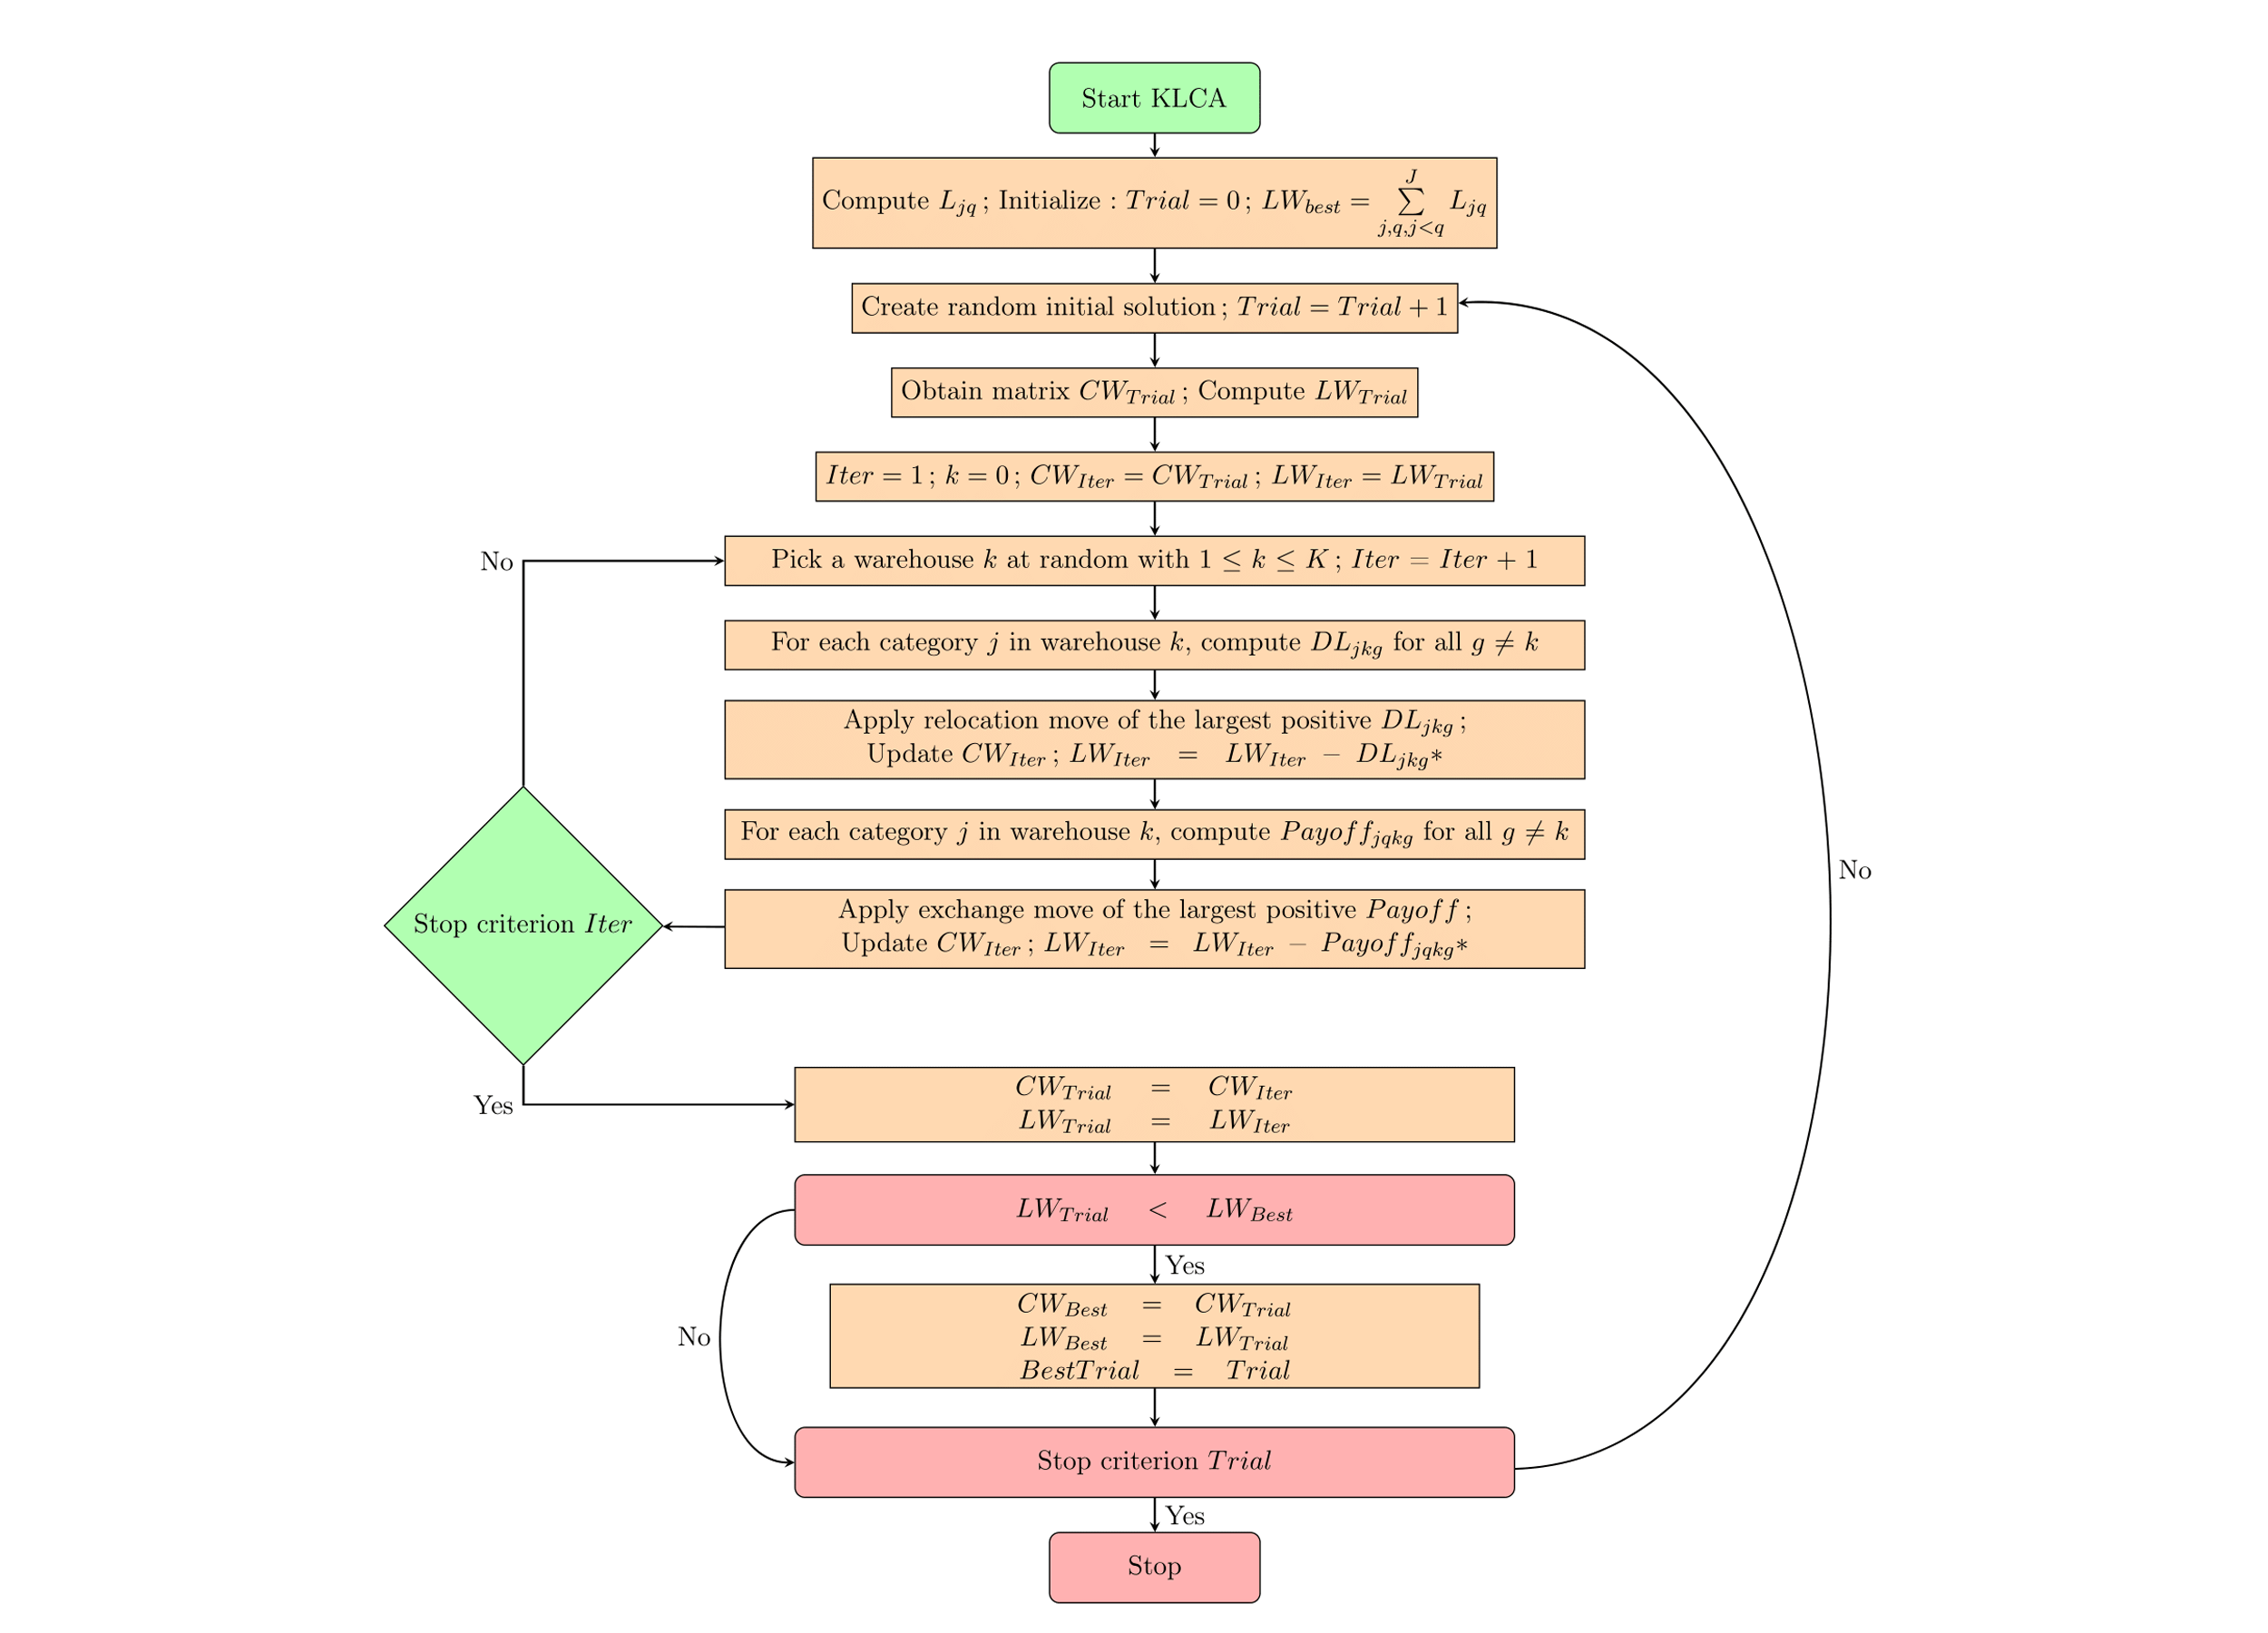

In [26]:
def main():
    
    'KLCA-HEURISTIC'
    global orders, categories, warehouses, Card, NMin, NMax, x
    global I, J, K

    'VAR INIT'
    LWBest = 0
    CWBest = []

    'Plot Var Init'
    LWTrialPlot = []
    LWBestPlot = []

    'VALUE INIT'
    LWBest = init_LWBest()
    trial = 0
    BestTrial = 0
    TrialNonImprovedBound = 30

    'LOOP - Trial'
    while(trial-BestTrial) <= TrialNonImprovedBound and trial <= 25: #Stopping criterion
        
        'Feasible Solution Building'
        randomize_category_allocation()
        matrix_init()

        trial = trial + 1

        'INIT LOOP - Iter'
        CWtrial = matrix_init_CW()
        LWtrial = init_LW()
        LWiter = int(LWtrial)
        ITER = 1
        improved = True
        k = 0
        previous = -1

        'LOOP - Iter'
        while improved and ITER <= 5 :

            ITER = ITER + 1

            'Warehouse Selection Depending On Obvious Criteria'
            selection = 0
            while (Card[k] == NMin[k] or k == previous) and selection < 20 :
                selection = selection + 1
                k=np.random.randint(len(warehouses))
            previous = k

            'Finding the best relocation feasible movement'
            DLBiggest= 0
            DL = 0
            if Card[k] > NMin[k] :
                for j in range(len(categories)):
                    if x[j][k] == 1:
                        for g in range(len(warehouses)):
                            if g != k and (NMax[g] - Card[g]) >= 1:
                                DL = calcul_DL(j, k, g)
                                if DL > DLBiggest:
                                    DLBiggest = DL
                                    to_move=j
                                    current_war = k
                                    new_war=g
            else :
                if ITER >= 5 :
                    improved = False
            if DLBiggest > 0 and improved:
                relocate_move(to_move, current_war, new_war)
                LWiter = LWiter - DLBiggest
            else:
                if ITER >= 5 :
                    improved=False

            'Finding the best valuable exchange movement'
            PayoffBiggest = 0
            Payoff = 0
            for j in range(len(categories)):
                if x[j][k] == 1:
                    for g in range(len(warehouses)):
                        if g != k :
                            for i in range(j+1, len(categories)):
                                if x[i][g] == 1 and i != j:
                                    Payoff = calcul_payoff(j, i, k, g)
                                    if Payoff > PayoffBiggest:
                                        PayoffBiggest = Payoff
                                        cat1 = j
                                        cat2 = i
                                        war1 = k
                                        war2 = g
            if PayoffBiggest > 0 :
                exchange_move(cat1, cat2, war1, war2)
                LWiter = LWiter - PayoffBiggest
            else:
                if ITER >= 5 :
                    improved=False

        CWtrial = matrix_init_CW()
        LWtrial = int(LWiter)
        LWTrialPlot.append(LWtrial)
        
        if LWtrial < LWBest:
            CWBest = list(CWtrial)
            LWBest = LWtrial
            OUTLBest = OUTL
            BestTrial = int(trial)
        LWBestPlot.append(LWBest)

    Check = error_check_allocation()
    if Check == True:
        print('The final solution is not feasible. Check the code')
    else:
        display(CWBest, LWBest, LWBestPlot, LWTrialPlot, trial)
        #display_verif(CWBest)
        #display_verif_CPLEX(CWBest)
    #KLCA-End'

***
## Execution
> All the necessary steps have been completed and the algorithm can be called to solve the **Order Split Minimization Problem**.

-----------------------------------------------------------------------
---------------------------- Final Solution ---------------------------
-----------------------------------------------------------------------


 Warehouse  1  should store the categories :   { 2, 11, }

 Warehouse  2  should store the categories :   { 4, 6, 7, 8, 10, }

 Warehouse  3  should store the categories :   { 1, 3, 5, 9, 12, 13, 14, 15, }

 Final objective function LWBest =  445

-------------------------- Results Analysis --------------------------



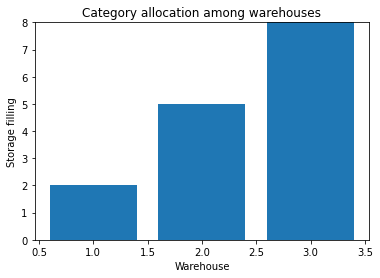

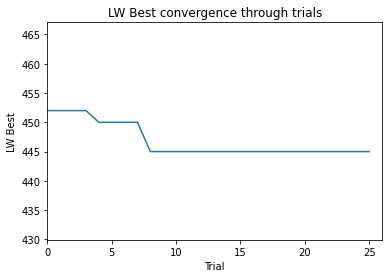

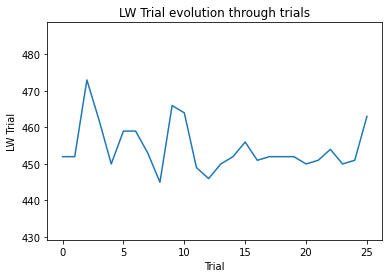

-----------------------------------------------------------------------
-------------------------------- END ----------------------------------
-----------------------------------------------------------------------



In [27]:
#START
    
for i in range(1): 
    'Testing multiple times'
    data_sizing(I,J,K)
    link_init()
    main()

#END